This file is part of GaPSE
Copyright (C) 2022 Matteo Foglieni

GaPSE is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

GaPSE is distributed in the hope that it will be useful, but
WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU
General Public License for more details.

You should have received a copy of the GNU General Public License
along with GaPSE. If not, see <http://www.gnu.org/licenses/>.
```


```

# Generic Window

This is a small tutorial in order to show how to use GaPSE when one is interested in the power spectrum obtained with a generic window function, and not with the toy-model we implemented.
The theoretical formula we will use is the following (Eq.(2.13) of Castorina, Di Dio (2021)); we remember that all the distances $s, s_1, s_2$ are comoving distances measured in $h_0^{-1}\mathrm{Mpc}$:

$$
    \left\langle \hat{P}_L(k) \right\rangle = 
        \frac{2 L + 1}{A} (-i)^L
        \sum_{\ell=0}^{\infty} 
        \sum_{\ell_1=0}^{\infty} 
        \begin{pmatrix}
            L & \ell & \ell_1 \\
            0 & 0 & 0
        \end{pmatrix}^2
        \int_0^{\infty}\!\mathrm{d} s \, s^2 \, \xi_\ell(s, s_{\rm eff}) \, 
        j_L(k s) \, Q_{\ell_1}(s) \, ,
$$

where:
- $\left\langle \hat{P}_L(k) \right\rangle$ is the order $L$ Power Spectrum of the effect we are interested in; we are basing this expression on the Yamamoto estimator (see Yamamoto (2000) and Yamamoto (2006))
- $A$ is a normalization constant
- the 2x3 matrix represents the Wigner-3j symbols
- $\xi_\ell$ is the order $\ell$ multipole of the Two-Point Correlation Function (TPCF)
- $j_L$ is the spherical Bessel function of order $L$
- $s_{\mathrm{eff}}$ is the comoving distance associated with the effective redshift (see the `TUTORIAL.ipynb` notebook)

$Q_{\ell_1}$ can be easily estimated with FFT methods:

$$
\begin{split}
    Q_{\ell_1}(s) &:= \int_0^{\infty}\mathrm{d}s_1 \; s_1^2 \;
    \phi(s_1) \; F_{\ell_1}(s_1, s) \\
    F_{\ell_1} (s_1 , s) &:= 
    \int_{4\pi} \mathrm{d}\Omega_{\mathbf{\hat{s}}} \,  
    \int_{4\pi} \mathrm{d}\Omega_{\mathbf{\hat{s}}_1} \,
    \phi(s_2) \, W(\mathbf{\hat{s}}_1) \, W(\mathbf{\hat{s}}_2) \,
    \mathcal{L}_{\ell_1}(\mathbf{\hat{s}} \cdot \mathbf{\hat{s}}_1)  \, .
\end{split}
$$

where:
- $\mathcal{L}_{\ell_1}$ is the Legendre polynomial of order $\ell_1$
- $\mathrm{d}\Omega_{\mathbf{\hat{s}}}$ is the infinitesimal solid angle pointing in the direction of the versor $\mathbf{\hat{s}}$
- $\phi(s)$ and  $W(\mathbf{\hat{s}})$ are respectively the radial and angular part of your window function (we remember that we assumed that such separability of the window function is possible)

Suppose we want the Power Spectrum of the Galaxy Number Counts (GNC) General Relatvistic (GR) effects. The idea is simple:
- first of all, you must compute the $Q_{\ell_1}(s)$ multipoles ($0 \leq \ell_1 \leq 4$ should be enough in almost all the realistic cases, but depending on your specific choise maybe you could even need less than that) and store them in a file let's call it `Ql_multipoles.txt`.  The file should have the following structure:
```text
    $ cat Ql_multipoles.txt 
    # Any comment line in the file must start with a #
    # you can have how many comment lines you want in the header; they 
    # will be all skipped.
    # Then you must provide in blank space separated columns:
    # - as first column, the comoving distance values, measured in Mpc/h_0
    # - from the second column onwards, all the Q_{\ell_1} multipoles you want;
    #   they must be ordered followinf the ascending multipole order (so \ell_1 = 0
    #   must be the 2 column), and you can go as further as you want in the multipole
    #   order
    # 
    # s [Mpc/h_0] 	 Q_{l1=0} 	 Q_{l1=1} 	 Q_{l1=2} 	 ...
    1.0 	0.9999999999999999 	 1.445269850978461e-7 	 0.000011917268941324522	...
    21.0	0.9832914433168294 	 -0.0025537781362117177  -0.0033199998619560947	    ...
    41.0	0.9669175943095181 	 -0.004923364937797496 	 -0.006463561496567318	    ... 	
    ... 	... 				 ... 					 ...
```

- then you can proceed in the computation of all the GNC Two-Point Correlation Functions (TPCFs) for the same multipole orders, setting `use_windows=false`
- finally, you'll use the functions `create_file_for_XiMultipole` and `PS_multipole_GenWin` , and you'll get the PS multipole described in the previous equation.

In [1]:
DIR = "Generic_Window/";
COMPUTE_XIS_GNC = false;

## Creation of a Cosmology

As always, let's create a Cosmology struct. Note that, even if you want to study your window function and you are not interested in the toy-model one, it's (currently) mandatory to provide the files for a WindowF and a WindowFIntegrated anyway. Just give the default ones in the `Data` directory (even if are suited for a different redshift bin, it does not matter).

Just remember to ALWAYS SET `use_windows = false` in each TPCF computation! 

In [2]:
PATH_TO_GAPSE = "../";

In [3]:
include(PATH_TO_GAPSE * "src/GaPSE.jl");

In [4]:
using DelimitedFiles, Plots, Dierckx, SpecialFunctions, TwoFAST, ProgressMeter
using Printf, LaTeXStrings, GridInterpolations, LegendrePolynomials

In [5]:
#FILE_F_MAP =  PATH_TO_GAPSE * "data/NEW_F_pi2.txt";
FILE_F_MAP =  PATH_TO_GAPSE * "data/F_REFERENCE_pi2.txt";
#=
kwargs_map_F_hcub = Dict(
     :θ_max => π / 2.0, :tolerance => 1e-10, 
     :rtol => 1e-2, :atol => 1e-3, :pr => true,
);

kwargs_map_F_trap = Dict(
     :θ_max => π / 2.0, :tolerance => 1e-10, 
     :N => 1000, :pr => true,
);

xs = [x for x in 0:0.02:5]
μs = union(
    [μ for μ in range(-1.0, -0.98, length = 50)], 
    [μ for μ in range(-0.98, 0.98, length = 102)],
    [μ for μ in range(0.98, 1.0, length = 50)]);
GaPSE.print_map_F(FILE_F_MAP, xs, μs; 
    alg = :trap, Fmap_opts = kwargs_map_F_trap # we recommend to use :trap
    #alg = :hcub, Fmap_opts = kwargs_map_F_hcub # but you can use also :hcub if you prefer
)
=#

In [6]:
z_min, z_max, θ_max = 1.0, 1.5, π / 2.0

FILE_BACKGROUND = PATH_TO_GAPSE * "data/WideA_ZA_background.dat";

#=
WFI_opts = Dict(
    :llim => nothing, :rlim => nothing, 
    :rtol => 1e-2, :atol => 0.0, 
    :N => 1000, :pr => true,
)
=#

params = GaPSE.CosmoParams(z_min, z_max, θ_max;
    Ω_b = 0.0489, Ω_cdm = 0.251020, h_0 = 0.70, s_lim=1e-2,
    b1 = 1.5, s_b1 = 0.0, 𝑓_evo1 = 0.0,
    b2 = nothing, s_b2 = nothing, 𝑓_evo2 = nothing,
    IPS_opts = Dict(
        :fit_left_min => 1e-6, :fit_left_max => 3e-6,
        :fit_right_min => 1e1, :fit_right_max => 2e1),
    IPSTools_opts = Dict(
        :N => 1024, :fit_min => 0.05, :fit_max => 0.5, 
        :con => true, :k_min => 1e-8, :k_max => 10.0),
    #=
    WFI_opts = Dict(
        :llim => nothing, :rlim => nothing, 
        :rtol => 1e-2, :atol => 0.0, 
        :N => 1000, :pr => true,)
    =#
);

In [7]:
#FILE_F_MAP =  PATH_TO_GAPSE * "data/NEW_F_pi2.txt";
#FILE_IF_MAP = PATH_TO_GAPSE * "data/NEW_IntegrF_pi2_z115.txt";

#FILE_F_MAP = PATH_TO_GAPSE*"data/F_REFERENCE_pi2.txt";
FILE_IF_MAP = PATH_TO_GAPSE*"data/IntegrF_REFERENCE_pi2_z115.txt";

#=
calc_μs = union(
    [μ for μ in range(-1.0, -0.98, length = 50)], 
    [μ for μ in range(-0.98, 0.98, length = 102)],
    [μ for μ in range(0.98, 1.0, length = 50)]);

GaPSE.print_map_IntegratedF(
    z_min, z_max, calc_μs,
    FILE_F_MAP, FILE_IF_MAP, 
    FILE_BACKGROUND;
    alg = :trap, N_ss = 200, m = 2.1,
    Dict(
        :llim => nothing, :rlim => nothing, 
        :rtol => 1e-2, :atol => 0.0, 
        :N => 1000, :pr => true,
    )...
)
=#

In [8]:
FILE_PS = PATH_TO_GAPSE * "test/datatest/file_pk.txt";
cosmo = GaPSE.Cosmology(params, FILE_BACKGROUND, FILE_PS, FILE_F_MAP, FILE_IF_MAP);

GaPSE.parameters_used(stdout, cosmo)

###############
#    GaPSE    #
############### 
#
# The Cosmology considered had the following paremeters:
# 
# - Matter Power Spectrum input file: "../test/datatest/file_pk.txt"
# - Background data input file: "../data/WideA_ZA_background.dat"
# - F window function input file: "../data/F_REFERENCE_pi2.txt"
# - Integrated F window function input file: "../data/IntegrF_REFERENCE_pi2_z115.txt"
#
# - Basic CosmoParams considered: 
#	 z_min = 1.0 	 z_max = 1.5
#	 θ_max = 1.5707963267948966 [rad] 	 h_0 = 0.7
#	 Ω_b = 0.0489 	 Ω_cdm = 0.25102 	 Ω_M0 = 0.29992
#	 b = 1.5 	 f_evo = 0.0 	 s_b = 0.0
#
# - CosmoParams about the Input Power Spectrum: 
#	 fit_left_min = 1.0e-6 	 fit_right_min = 10.0 	 
#	 fit_left_max = 3.0e-6 	 fit_right_max = 20.0 	 
#
# - CosmoParams about the Input Power Spectrum Tools: 
#	 k_max = 10.0 	 fit_max = 0.5 	 N = 1024 	 
#	 con = true 	 k_min = 1.0e-8 	 fit_min = 0.05 	 
#
# - Computed quantities: 
# 	 effective redshift z_eff = 1.2613556177172358 
# 	 comoving s_m

## Ql multipoles

For this tutorial, we will consider again as window function the azimutally simmetry toy-model one described in the `TUTORIAL.ipynb`. 
However, we will not exploit its peculiar simmetry to get a simplified analitical expression; we will instead use the general Power Spectrum equation described at the beginning of this notebook. 

In order to do so, the only equation we miss is the one relating the window function $F(x,\mu)$ (that we can compute with the GaPSE functions) and the multipoles $F_{\ell_1}$. Having a look at Eq.(A.11-12) of Castorina, Di Dio (2021), we have: 

$$
\begin{split}
    F(s_1, s_ \mu) :&= \phi\left(\sqrt{s_1^2 + s^2 + 2 \, s_1 \, s \, \mu}\right) \; F\left(\frac{s}{s_1}, \mu\right) \\
                    &= \sum_{l_1=0}^{\infty} \frac{2 \ell_1 + 1}{2} \, \mathcal{L}_{\ell_1}(\mu) \, F_{\ell_1}(s_1,s)
\end{split}
$$

$$
\Rightarrow \quad F_{\ell_1}(s_1,s) = \int_{-1}^{+1}\mathrm{d}\mu \; \mathcal{L}_{\ell_1}(\mu) \; 
    \phi\left(\sqrt{s_1^2 + s^2 + 2 \, s_1 \, s \, \mu}\right) \; F\left(\frac{s}{s_1}, \mu\right) 
$$

All the analitical formulae necessary to compute $Q_{\ell_1}$ from $F(x,\mu)$ are written down; we must make the integral over $\mathrm{d}\mu$ first (with $\mathcal{L}_{\ell_1}(\mu) \; \phi\left(\sqrt{s_1^2 + s^2 + 2 \, s_1 \, s \, \mu}\right)$ as weight) and then the one over $\mathrm{d}s_1$ (with $s_1^2 \; \phi(s_1) $ as weight).
There is however a useful trick: we can invert the integration order, making firstly the one over $\mathrm{d}s_1$ and then the one over $\mathrm{d}\mu$. his allow us to avoid to compute the $\mathrm{d}s_1$ integral, because that expression is exactly the definition of the Integrated window function $\mathcal{F}(s,\mu)$ that we already computed!

$$
\begin{split}
    Q_{\ell_1}(s) :
        &= \int_0^{\infty}\mathrm{d}s_1 \; s_1^2 \; \phi(s_1) \; F_{\ell_1}(s_1, s) \\
        &= \int_0^{\infty}\mathrm{d}s_1 \; s_1^2 \; \phi(s_1) \; 
            \int_{-1}^{+1}\mathrm{d}\mu \; \mathcal{L}_{\ell_1}(\mu) \; 
            \phi\left(\sqrt{s_1^2 + s^2 + 2 \, s_1 \, s \, \mu}\right) \; 
            F\left(\frac{s}{s_1}, \mu\right) \\
        &= \int_{-1}^{+1}\mathrm{d}\mu \; \mathcal{L}_{\ell_1}(\mu) \; 
            \int_0^{\infty}\mathrm{d}s_1 \; s_1^2 \; \phi(s_1) \; 
            \phi\left(\sqrt{s_1^2 + s^2 + 2 \, s_1 \, s \, \mu}\right) \; 
            F\left(\frac{s}{s_1}, \mu\right) \\
        &= \int_{-1}^{+1}\mathrm{d}\mu \; \mathcal{L}_{\ell_1}(\mu) \; \mathcal{F}(s,\mu)
\end{split}
$$

We then implemented in the code the function `print_map_WindowFIntegrated_multipole` for such computation

```julia
print_map_WindowFIntegrated_multipole(
          ss::Vector{Float64},
          windowFint::Union{String,GaPSE.WindowFIntegrated}, out::String;
          s_min, s_max,
          pr::Bool=true, L_max::Int=4, alg::Symbol=:lobatto,
          N_lob::Int=100, N_trap::Int=200,
          atol_quad::Float64=0.0, rtol_quad::Float64=1e-2,
          enhancer::Float64=1e6)

     print_map_WindowFIntegrated_multipole(
          s_zs::Vector{Float64},
          windowFint::Union{String,GaPSE.WindowFIntegrated}, out::String,
          file_data::String; z_min, z_max,
          names_bg=GaPSE.NAMES_BACKGROUND, h_0=0.7, kwargs...))

     print_map_WindowFIntegrated_multipole(
          windowFint::Union{String,GaPSE.WindowFIntegrated}, out::String,
          file_data::String; z_min, z_max,
          names_bg=GaPSE.NAMES_BACKGROUND, h_0=0.7, N::Int=100, 
          m::Float64=2.1, st::Float64=0.0, kwargs...)
```

Evaluate the integrated window function multipoles $Q_{\ell_1}(s)$ in a vector of $s$ values for all
the multipoles $0 \leq \ell_1 \leq L_\mathrm{max}$, and print the results in the `out` file.
The computation of the multipole is performed through `WindowFIntegrated_multipole`.

The first method takes as input:
- `ss::Vector{Float64}` :  the vector of s points where to 
  sample the integrated window function multipoles $Q_{\ell_1}$.`ss` must be a float vector of 
  increasing comoving distance values (so each element must be ≥ 0); the first and last values 
  ARE NOT RELATED to `s_min` and `s_max`.
- `windowFint::Union{String,WindowFIntegrated}`, i.e. the integrated window function itself; it can be 
  passed as the namefile where the integrated window is stored in (that will be opened with `WindowFIntegrated`) 
  or as a `WindowFIntegrated` struct directly.
- `out::String` : the name of the output file
- `s_min` and `s_max` (keyword arguments) : min and max comoving distance of the survey;
  their values will be internally used by 

The second method takes as input the min and max redshifts of the survey (`z_min`and `z_max`),
the vector of redshifts `zs::Vector{Float64}` for the integrated window function sampling, `windowFint` 
as before and the `file_data` where can be found the association $z \rightarrow s(z)$. 
Such file must have the structure of the 
background data produced by the [`CLASS`](https://github.com/lesgourg/class_public) code.
Note that also `zs` musyt be a float vector of increasing redshift values (so each element must be ≥ 0).
This method internally recalls the first one, so the other `kwargs...` are in common.

The third method takes as input the min and max redshifts of the survey (`z_min`and `z_max`) and the same 
input as the second method (`windowF`, `out` and `file_data`) but NOT THE REDSHIFT SAMPLING VECTOR `zs`.
The sampling will be internally made linearly from $s = \mathrm{st}$(where `st::Float64 = 0.0` is a 
keyword argument) to $s = m \, s_{\mathrm{max}}$, where `s_max` is the comoving distance associated to 
`z_max` (for the data stored in `file_data`) and `m::Float64 = 2.1` a coefficient that we 
suggest to set equals to `2 < m < 3`.
`N::Int = 100` is the number of `s` values used for the sampling in the interval 
$[0, m \, s_{\mathrm{max}}]$.
This method internally recalls the first one, so the other `kwargs...` are in common.

We have such $Q_{\ell_1}$ for the redshift bin $1.0 \leq z \leq 1.5$ multipoles already stored in the file `data/Ql_multipoles_of_F_REFERENCE_z115.txt`, until $L=4$. 
In the next outputs we show its header and a plot of them.

The command we used in order to produce such file is commened in the same cell.

In [9]:
#=
windowfint_z115 = GaPSE.WindowFIntegrated(PATH_TO_GAPSE*"data/IntegrF_REFERENCE_pi2_z115.txt");
GaPSE.print_map_WindowFIntegrated_multipole(windowfint_z115, PATH_TO_GAPSE*"data/PowerSpectrumGenwin/Ql_multipoles_of_F_REFERENCE_z115.txt", 
    PATH_TO_GAPSE*"data/WideA_ZA_background.dat"; z_min = 1.0, z_max=1.5, st = 1.0, N=1000, pr=true, L_max=4,
    alg=:lobatto, N_lob=100, N_trap=200, atol_quad=0.0, rtol_quad=1e-2, enhancer=1e6, h_0=0.7)
=#

name_file_Qmultipoles = PATH_TO_GAPSE*"data/Ql_multipoles_of_F_REFERENCE_z115.txt";
run(`head -n 20 $(name_file_Qmultipoles)`)

###############
#    GaPSE    #
############### 
#
# This is an integration map of the Q_{l_1} multipoles, defined as:
#      Q_{l_1}(s_1, s \mu) = \int_{-1}^{+1} \mathrm{d}\mu \mathcal{L}_{l_1}(\mu) \mathcal{F}(s, \mu)
#      \mathcal{F}(s, \mu) = \int_0^{\infty} \mathrm{d}s_1 s_1^2 \phi(s_1) \phi(\sqrt(s_1^2 + s^2 + 2 s_1 s \mu)) F(s/s_1, \mu)
# where \mathcal{L}_{l_1}(\mu) is tre Legendre polynomial if order l1 and
# F(x, \mu) is the window function considered (for its analytical definition, check the code).
#
#
# Time needed for this computation [in s]: 54.9950897693634
# The keyword arguments were:
#
# s [h_0^{-1} Mpc] 	 Q_{l_1=0} 	 Q_{l_1=1} 	 Q_{l_1=2} 	 Q_{l_1=3} 	 Q_{l_1=4} 	 
1.0 	 4.1857800000750543e11 	 -4.377435879373042e7 	 -5.084259164821501e8 	 1.2380785453994218e6 	 -3.641597411371149e8 	 
7.419834176318205 	 4.16656285072337e11 	 -3.247984840894028e8 	 -9.25042499972539e8 	 9.186336883352188e6 	 -2.832860726295231e8 	 
13.83966835263641 	 4.147345701371686e11 	 -6.058

Process(`head -n 20 ../data/Ql_multipoles_of_F_REFERENCE_z115.txt`, ProcessExited(0))

In [10]:
s_vec, all_Q_l1 = GaPSE.readxall(name_file_Qmultipoles);

┌ Warning: backend `PyPlot` is not installed.
└ @ Plots /Users/di75tom/.julia/packages/Plots/Hxe7H/src/backends.jl:37


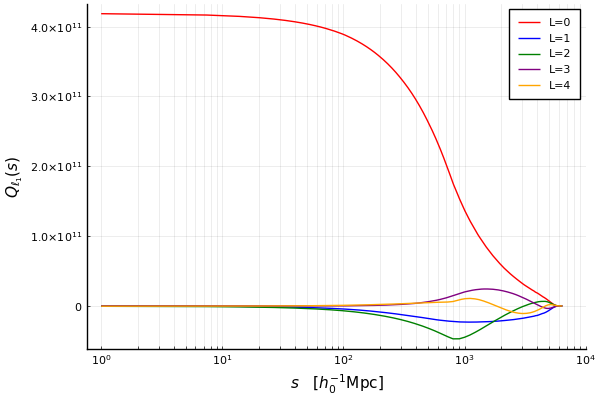

In [11]:
pyplot()
plot(s_vec, all_Q_l1[1], xaxis=:log, label="L=0", 
    xlabel=L"s \quad [h_0^{-1}\mathrm{Mpc}]", 
    ylabel=L"Q_{\ell_1}(s)",
    xticks = (
        vcat([a*10.0^b for b in 0:3 for a in 1:9], 10.0^4), 
        vcat([a==1 ? L"10^{%$b}" : nothing for b in 0:3 for a in 1:9], L"10^{4}")
    ),)
plot!(s_vec, all_Q_l1[2], xaxis=:log, label="L=1")
plot!(s_vec, all_Q_l1[3], xaxis=:log, label="L=2")
plot!(s_vec, all_Q_l1[4], xaxis=:log, label="L=3")
plot!(s_vec, all_Q_l1[5], xaxis=:log, label="L=4")

```


```
IMPORTANT NOTE: In order to obtain a correctly normalized Power Spectum, the multipoles $Q_{\ell_1}$ should be normalized properly, i.e. it should be true that:

$$
    \lim_{s \rightarrow 0^{+}} Q_{\ell_1 = 0}(s) = 1.0
$$

The code implemented in GaPSE DO NOT MAKE SUCH NORMALIZATION as you can see in the previous plot, you have to do it manually. Of course, because this is only an overall constant and nothing more, you can also compute the Power Spectrum without normalization and divide only at the end for the first value  of the monopole $Q_{\ell_1=0}$, i.e. for all_Q_l1\[1\]\[1\], that in this case is equal to:

In [12]:
all_Q_l1[1][1]

4.1857800000750543e11

```


```

## Compute the TPCFs

 Here we give the code in order to compute all the TPCFs for the GNC group, without the observer velocity terms, until $L=4$.

In [10]:
name_xis_GNC_L0_noF_noobsvel_file = DIR * "xis_GNC_L0_noF_noobsvel_GenWin.txt";
name_xis_GNC_L1_noF_noobsvel_file = DIR * "xis_GNC_L1_noF_noobsvel_GenWin.txt";
name_xis_GNC_L2_noF_noobsvel_file = DIR * "xis_GNC_L2_noF_noobsvel_GenWin.txt";
name_xis_GNC_L3_noF_noobsvel_file = DIR * "xis_GNC_L3_noF_noobsvel_GenWin.txt";
name_xis_GNC_L4_noF_noobsvel_file = DIR * "xis_GNC_L4_noF_noobsvel_GenWin.txt";

In [11]:
if COMPUTE_XIS_GNC == true
    GaPSE.print_map_sum_ξ_GNC_multipole(
        cosmo, name_xis_GNC_L0_noF_noobsvel_file,
        10 .^ range(0, log10(2 * cosmo.s_max), length=500);
        use_windows=false, L=0, alg=:quad, obs=:noobsvel,
        single=true, enhancer=1e8,
        N_trap=200, N_lob=200, atol_quad=0.0, rtol_quad=1e-2,
        N_χs=100, N_χs_2=60
    )
end

In [12]:
if COMPUTE_XIS_GNC == true
    GaPSE.print_map_sum_ξ_GNC_multipole(
        cosmo, name_xis_GNC_L1_noF_noobsvel_file,
        10 .^ range(0, log10(2 * cosmo.s_max), length=500);
        use_windows=false, L=1, alg=:lobatto, obs=:noobsvel,
        single=true, enhancer=1e8,
        N_trap=200, N_lob=1000, atol_quad=0.0, rtol_quad=1e-2,
        N_χs=100, N_χs_2=50
    )
end

In [13]:
if COMPUTE_XIS_GNC == true
    GaPSE.print_map_sum_ξ_GNC_multipole(
        cosmo, name_xis_GNC_L2_noF_noobsvel_file,
        10 .^ range(0, log10(2 * cosmo.s_max), length=500);
        use_windows=false, L=2, alg=:quad, obs=:noobsvel,
        single=true, enhancer=1e8,
        N_trap=200, N_lob=1000, atol_quad=0.0, rtol_quad=1e-2,
        N_χs=100, N_χs_2=50
    )
end

In [14]:
if COMPUTE_XIS_GNC == true
    GaPSE.print_map_sum_ξ_GNC_multipole(
        cosmo, name_xis_GNC_L3_noF_noobsvel_file,
        10 .^ range(0, log10(2 * cosmo.s_max), length=500);
        use_windows=false, L=3, alg=:lobatto, obs=:noobsvel,
        single=true, enhancer=1e8,
        N_trap=200, N_lob=1000, atol_quad=0.0, rtol_quad=1e-2,
        N_χs=100, N_χs_2=50
    )
end

In [15]:
if COMPUTE_XIS_GNC == true
    GaPSE.print_map_sum_ξ_GNC_multipole(
        cosmo, name_xis_GNC_L4_noF_noobsvel_file,
        10 .^ range(0, log10(2 * cosmo.s_max), length=500);
        use_windows=false, L=4, alg=:lobatto, obs=:noobsvel,
        single=true, enhancer=1e8,
        N_trap=200, N_lob=1000, atol_quad=0.0, rtol_quad=1e-2,
        N_χs=100, N_χs_2=50
    )
end

## create_file_for_XiMultipoles function

In order to use the function `PS_multipole_GenWin`, that computes the chosen monopole of the Power Spectrum for an arbitrary window function, we must have a SINGLE file containing all the TPCFs multipoles of the effect we are interested in. To obtain such a file, we will exploit another GaPSE function, i.e. 

As "effect" we consider the sum of all the 25 GNC TPCFs, which is the second column in each one of the 5 files we produced in the previous section. Of course, if you are interested in a specific effect, the procedure will not change: simply you will select the appropriate column number.

```julia
create_file_for_XiMultipoles(out::String, names::Vector{String}, 
          effect::Union{String, Integer}, group::String="GNC"; 
          comments::Bool=true, xdt::DataType=Float64, ydt::DataType=Float64)
```


Read the column number `effect` (if is an Integer) or the one corresponding to the GR effect `effect`
for the input group `group` (if is a String) from all the filenames stored in the Vector `names`, 
and save them in a file named `out`.

The first column of `out` will be the same as the first column of the first filename in `names`; it
is however checked internally if the first column of all the other files coincides with this one.
The following columns of `out` follow the order in `names`. Note that `effect`, if passed as Integer,
must be > 1 (because 1 is the index of the first column, used as x-axis).

`group` must be one among the following: `["LD", "GNC", GNCxLD", LDxGNC", "generic"]`; if `group="generic"`, then `effect` must be an integer (because 
you are not selecting a specific effect in one of the native GaPSE groups).

`xdt` and `ydt` are the data types to be used for respectively the first column and the 2-3-4-... columns 
of `out`.
Set `comments=true` if the files in `names` start with a header that must be skipped (its lines must start with
#, otherwise they will not be recognised as comments).

In [17]:
name_file_ximultipoles = DIR*"xis_GNC_L01234_noF_noobsvel.txt"

vector_xis_names = [
    name_xis_GNC_L0_noF_noobsvel_file,
    name_xis_GNC_L1_noF_noobsvel_file,
    name_xis_GNC_L2_noF_noobsvel_file,
    name_xis_GNC_L3_noF_noobsvel_file,
    name_xis_GNC_L4_noF_noobsvel_file,
];

GaPSE.create_file_for_XiMultipoles(name_file_ximultipoles, vector_xis_names, 2, "GNC");

run(`head -n 18 $(name_file_ximultipoles)`)

###############
#    GaPSE    #
############### 
#
#
# This is a table containing the multipoles of the Two-Point Correlation Function (TPCF) 
# for the Galaxy Number Counts GR effect [not given, provied only the index 2]
#  taken from the files:
#   - L = 0 : Generic_Window/xis_GNC_L0_noF_noobsvel_GenWin.txt
#   - L = 1 : Generic_Window/xis_GNC_L1_noF_noobsvel_GenWin.txt
#   - L = 2 : Generic_Window/xis_GNC_L2_noF_noobsvel_GenWin.txt
#   - L = 3 : Generic_Window/xis_GNC_L3_noF_noobsvel_GenWin.txt
#   - L = 4 : Generic_Window/xis_GNC_L4_noF_noobsvel_GenWin.txt
#
# s [Mpc/h_0] 	xi_{L=0} 	 xi_{L=1} 	 xi_{L=2} 	 xi_{L=3} 	 xi_{L=4} 	 
1.0 	  5.113125676681059 	  -0.0015690999071494122 	  -1.0280456871294323 	  0.000428313051561901 	  0.04306900214953497 	 
1.0176234579394636 	  5.045580597784756 	  -0.001421005935473372 	  -1.021147873727164 	  0.0004060810841966568 	  0.043107470299322326 	 
1.0355575021486711 	  4.976778924402472 	  -0.0015078826643456617 	  -1.0143229607753146 	  0.000

Process(`head -n 18 Generic_Window/xis_GNC_L01234_noF_noobsvel.txt`, ProcessExited(0))

## PS_multipole_GenWin

It is now all set: we can compute the Power Spectrum for our generic window function, using as input the two files we produced to the GaPSE function `PS_multipole_GenWin`.

```julia
PS_multipole_GenWin(
      ximult::Union{XiMultipoles,String}, genwin::Union{GenericWindow,String};
      alg::Symbol=:fftlog, L::Int=0,
      cut_first_n::Int=0, cut_last_n::Int=0,
      kwargs...)
```

- `ximult::Union{XiMultipoles,String}` : Two-Point Correlation functions to be used in the computation. You can
  provide either a `XiMultipoles` struct containing them or the String filename where they are stored (that will 
  be internally open with `XiMultipoles` too). 
  The file must have a structure analogous to the `genwin` one (explained before). You can use 
  `create_file_for_XiMultipoles` to produce such a file.

- `genwin::Union{GenericWindow,String}` : multipoles $Q_{\ell_1}$ of the generic window function you want 
  to consider. You can provide either a `GenericWindow` struct containing them or the String filename 
  where they are stored (that will be internally open with `GenericWindow` too). 
  The file must have the following structure explained before
  
All the other options (`kwargs...` included) are the same as for the "standard" `PS_multipole` explained in the `TUTORIAL.ipynb`.
We give finally the practically usage:


time needed for this Power Spectrum computation [in s] = 0.05814099311828613


time needed for this Power Spectrum computation [in s] = 0.0006098747253417969



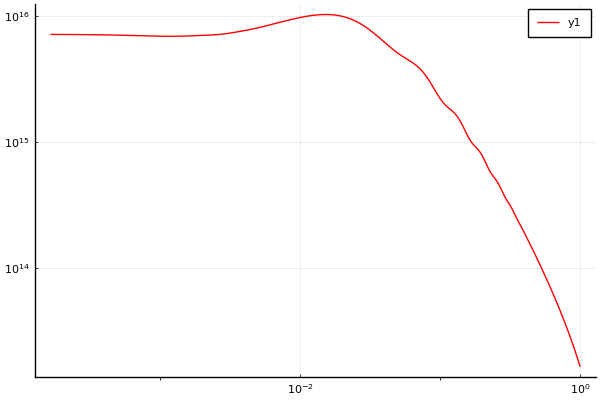

In [20]:
ps_kwargs(alg::Symbol = :fftlog) = alg == :twofast ?
    Dict(
        :alg => :twofast, :epl => true, :pr => false, 
        :N_left => 12, :N_right => 12,
        :p0_left => [-2.0, 1.0], :p0_right => [-2.0, 1.0],
        :int_s_min => 1e0, :int_s_max => 1200.0,
        :cut_first_n=>0, :cut_last_n => 0
    ) : alg == :fftlog ?
    Dict(
        :alg => :fftlog, :pr=>true, :ν => 1.5, 
        :n_extrap_low => 0, :n_extrap_high => 0, 
        :n_pad => 500, :cut_first_n=>0, :cut_last_n => 0,
    ) : throw(AssertionError("alg = :fftlog (recommended) or alg = :twofast !"));
tf = :fftlog;

ks, pks = GaPSE.PS_multipole_GenWin(name_file_ximultipoles, name_file_Qmultipoles; L=0, ps_kwargs(:fftlog)...);
#ks, pks = GaPSE.PS_multipole_GenWin(name_file_ximultipoles, "../../GaPSE-free-ipynb/ARTICLE_RESULTS/ARTICLE_GenWin/QL_s_Lmax4.dat"; 
#    L=0, ps_kwargs(:fftlog)...);
plot(ks[pks.≠0],abs.(pks)[pks.≠0], axis=:log)

We can compare the previous result with the "standard one" obtained exploting the analytical solution based on the properties of azimutally simmetric window fuction we are using. The Power Spectrum of the 25 GNC effects sum is stored in `ps_GNC_L0_withF_noobsvel_GenWin.txt`(there is also `xis_GNC_L0_withF_noobsvel_GenWin.txt` if you are interested).

We must of course remember to divide the PS here computed by the normalization constant `all_Q_l1[1][1]`

In [21]:
true_ks, true_pks, true_all_pks = GaPSE.readxyall(DIR*"ps_GNC_L0_withF_noobsvel_GenWin.txt");

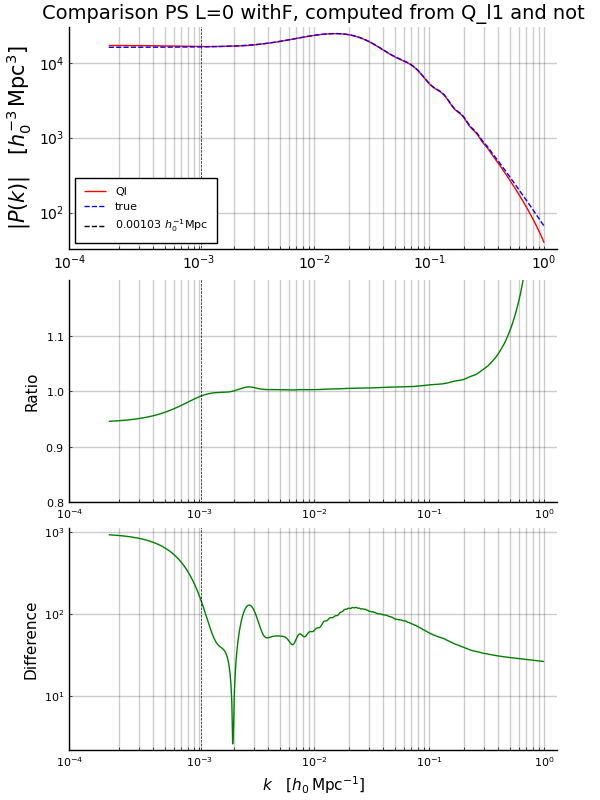

In [22]:
pyplot()

xs_1 = ks
ys_1 = pks ./ all_Q_l1[1][1]

xs_2 = true_ks
ys_2 = true_pks
spline = Spline1D(xs_2, ys_2)


S_VLIM = 2*π/(2*cosmo.s_max)
S_VLIM_F = @sprintf("%.5f", S_VLIM)

p1 = plot([xs_1, xs_2], [abs.(ys_1), abs.(ys_2)],
    xaxis=:log, yaxis=:log, grid=true, gridalpha=0.2,gridlinewidth=1,
    yticks=[10.0^i for i in 2:5], tickfontsize = 10, labelfontsize=15,
    xticks = (
        vcat([a*10.0^b for b in -4:(-1) for a in 1:9], 10.0^0), 
        vcat([a==1 ? L"10^{%$b}" : nothing for b in -4:(-1) for a in 1:9], L"10^{0}")
    ),
    lc=[:red :blue], 
    title = "Comparison PS L=0 withF, computed from Q_l1 and not",
    label=["Ql" "true"], ls=[:solid :dash], 
    ylabel = L"|P(k)| \quad [h_0^{-3}\,\mathrm{Mpc}^3]",
    legend=:bottomleft)
vline!(p1, [S_VLIM], label="$S_VLIM_F " * L" h_0^{-1}\mathrm{Mpc}", lc=:black, lw=0.5, ls=:dash)

p2 = plot(xs_1, spline.(xs_1) ./ ys_1, 
    ylabel="Ratio", lc=:green, 
    xaxis=:log,grid=true, gridalpha=0.2,gridlinewidth=1,
    ylim=(0.8,1.2), 
    legend=false, 
    xticks = (
        vcat([a*10.0^b for b in -4:(-1) for a in 1:9], 10.0^0), 
        vcat([a==1 ? L"10^{%$b}" : nothing for b in -4:(-1) for a in 1:9], L"10^{0}")
    ),
    #xlabel=L"$k \quad [h_0 \,\mathrm{Mpc}^{-1}]$",
    )
vline!(p2, [S_VLIM], label="$S_VLIM_F " * L" h_0^{-1}\mathrm{Mpc}", lc=:black, lw=0.5, ls=:dash)

p3 = plot(xs_1, abs.(spline.(xs_1) .- ys_1), 
    ylabel="Difference", lc=:green, 
    axis=:log, grid=true, gridalpha=0.2,gridlinewidth=1,
    #ylim=(0.0,2), 
    xticks = (
        vcat([a*10.0^b for b in -4:(-1) for a in 1:9], 10.0^0), 
        vcat([a==1 ? L"10^{%$b}" : nothing for b in -4:(-1) for a in 1:9], L"10^{0}")
    ),
    legend=false, 
    xlabel=L"$k \quad [h_0 \,\mathrm{Mpc}^{-1}]$")
VAXES = 4e-3
vline!(p3, [S_VLIM], label="$VAXES Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

P = plot(p1, p2, p3, size=(600, 800), layout= @layout [ x ; y ; z ] )
#savefig(P, DIR*"ps_comparison.pdf")
#display(P)

The two curves are very similar, and the differences are easily explained:
- The $<5\%$ difference at small $k$s it's due to the fact that the TPCFs should be computed further than $2 \, s_{\mathrm{max}}$ when you want to use this PS formula; if you also expand them with a power law for greater $s$ values, this difference disappear. Also it's worth to mention that such difference affects the PS outside the minimum $k$ inside the survey (equals to $k_{\mathrm{min}} = 2 \pi / (2 \, s_{\mathrm{max}})$, and showed with a black dashed vertical line in the plot)
- the $>10\%$ difference at large $k$s it's instead related with the minimum sampled comoving distance value for the TPCFs, which is $1 \, h_0^{-1}\mathrm{Mpc}$; consequently, for $k > 2 \pi/(1 h_0^{-1}\mathrm{Mpc}) \simeq 6 h_0 \mathrm{Mpc}^{-1}$ the PS doesn't exist anymore, and the close you get to that limit the more the PS is affected by such artefact. Again, if you expand the TPCFs further to 0 (i.e. set `:n_extrap_high => 100` in the fftlog options, for example), the problem disappear.

## END